In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [3]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [4]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [5]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
#settle_value = df.settle.pct_change() * 100
#settle_value.plot()

yen_futures['Returns'] = yen_futures[['Settle']].pct_change() *100
yen_futures = yen_futures.replace(-np.inf,np.nan).dropna()

In [6]:
yen_futures.head(10)

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Returns
Date,,,,,,,,,
2014-02-18,9831.0,9865.0,9734.0,9775.0,42.0,9775.0,203495.0,196924.0,-0.427829
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502
2014-02-25,9760.0,9808.0,9744.0,9789.0,32.0,9789.0,105498.0,201486.0,0.327970
2014-02-26,9784.0,9795.0,9746.0,9760.0,29.0,9760.0,118559.0,200105.0,-0.296251
2014-02-27,9769.0,9831.0,9762.0,9798.0,38.0,9798.0,160638.0,201246.0,0.389344
2014-02-28,9787.0,9848.0,9776.0,9825.0,27.0,9825.0,169374.0,200184.0,0.275566


### Lagged Returns 

In [7]:
# Create a lagged return using the shift function

yen_futures['Lagged_returns'] = yen_futures['Returns'].shift()
yen_futures = yen_futures.dropna()
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Returns,Lagged_returns
Date,,,,,,,,,,
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460,-0.427829
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465,-0.020460
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604,0.020465
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502,-0.204604
2014-02-25,9760.0,9808.0,9744.0,9789.0,32.0,9789.0,105498.0,201486.0,0.327970,0.020502


### Train Test Split

In [8]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2017']
test = yen_futures['2018':]

In [9]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):

X_train = train['Lagged_returns'].to_frame()
y_train = train['Returns']
X_test = test['Lagged_returns'].to_frame()
y_test = test['Returns']

In [10]:
X_train

,Lagged_returns
Date,
2014-02-19,-0.427829
2014-02-20,-0.020460
2014-02-21,0.020465
2014-02-24,-0.204604
2014-02-25,0.020502
...,...
2017-12-22,0.084621
2017-12-26,0.118370
2017-12-27,0.118230


# Linear Regression Model

In [11]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):

model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [43]:
# Make a prediction of "y" values using just the test dataset

pred = model.predict(X_test)
pred

array([-0.00862124, -0.00888545, -0.00692339, -0.00702354, -0.00650945,
       -0.00802706, -0.00921926, -0.01203973, -0.00865099, -0.00786138,
       -0.01026426, -0.00513322, -0.00812407, -0.00909274, -0.00647317,
       -0.01000139, -0.01203513, -0.00653118, -0.01028917, -0.00689127,
       -0.0083558 , -0.00667268, -0.00672874, -0.00499329, -0.00966691,
       -0.00895868, -0.00756199, -0.00953327, -0.0088314 , -0.00740552,
       -0.01108511, -0.00987929, -0.01054993, -0.00758792, -0.00450909,
       -0.0060618 , -0.01164882, -0.00745109, -0.0071785 , -0.00608657,
       -0.01034511, -0.00912245, -0.01020218, -0.0055113 , -0.00774271,
       -0.00834298, -0.00714339, -0.00598   , -0.0091635 , -0.00694742,
       -0.00896721, -0.00776203, -0.00832406, -0.00770403, -0.00888483,
       -0.00888162, -0.00949421, -0.01053989, -0.00635589, -0.00665555,
       -0.0031288 , -0.00927488, -0.00973257, -0.00526427, -0.00729768,
       -0.00530112, -0.00979091, -0.00797544, -0.00648187, -0.00

In [13]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:

res = y_test.to_frame()
res['Predicted Results'] = pred

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

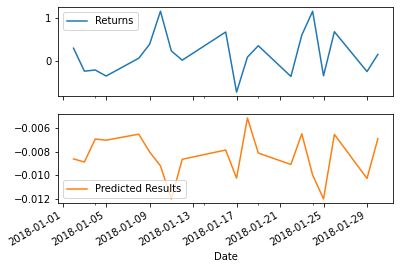

In [14]:
# Plot the first 20 predictions vs the true values

res[:20].plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [63]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(y_test, pred)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)

print(mse)
print(rmse)

0.17262635470120388
0.4154832784856737


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [64]:
# Construct a dataframe using just the "y" training data:
train_data_y = y_train.to_frame()
train_data_y.head()

,Returns
Date,
2014-02-19,-0.020460
2014-02-20,0.020465
2014-02-21,-0.204604
2014-02-24,0.020502
2014-02-25,0.327970


In [65]:
# Add a column of "in-sample" predictions to that dataframe:  
train_data_y["In-sample Predictions"] = model.predict(X_train)

train_data_y.head()

,Returns,In-sample Predictions
Date,,
2014-02-19,-0.020460,-0.006240
2014-02-20,0.020465,-0.007726
2014-02-21,-0.204604,-0.007875
2014-02-24,0.020502,-0.007054
2014-02-25,0.327970,-0.007876


In [69]:
# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, pred)
mse

0.17262635470120388

In [67]:
# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
rmse = np.sqrt(mse)
rmse

0.4154832784856737

# Conclusions

YOUR CONCLUSIONS HERE!

The MSE of 0.17 is the line of best fit

In [ ]:
The model has a root mean square error of 0.415% on out-of-sample data and 0.0.172% on in-sample data. the model performs better with out of sample data